In [1]:
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

### Importando Dados

In [2]:
train_df = pd.read_csv('data/train_processed.csv')
test_df = pd.read_csv('data/test_processed.csv')

train_data, val_data = train_test_split(train_df, test_size=0.25, random_state=42)

In [3]:
train_df.head(10)

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,...,Arrival Delay in Minutes,Jovem,Adulto,Idoso,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,0.8,...,0.56250,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,0.2,...,0.18750,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.224354,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.8,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.107229,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,0.4,...,0.28125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.036955,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,0.6,...,0.00000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0.232027,0.6,0.8,0.4,0.2,0.2,0.4,0.2,0.2,0.6,...,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,0.251414,0.4,0.8,0.4,0.6,0.4,0.4,0.4,0.4,0.6,...,0.71875,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,0.404685,0.8,0.6,0.8,0.8,1.0,1.0,1.0,1.0,1.0,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.165994,0.2,0.4,0.4,0.4,0.8,0.6,0.6,0.2,0.2,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.207997,0.6,0.6,0.6,0.8,0.4,0.6,0.6,0.4,0.4,...,0.00000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [4]:
train_df.dtypes

Flight Distance                      float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
Cleanliness                          float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Jovem                                float64
Adulto                               float64
Idoso                                float64
Gender_Male                          float64
Customer Type_disloyal Customer      float64
Type of Tr

### Criando os Datasets e DataLoaders

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row[:-1].values.astype('float32')
        label = row[-1].astype('int64')

        features = torch.tensor(features)
        label = torch.tensor(label)

        return features, label

In [5]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_df)

BATCH_SIZE = 32
#NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

### Funcoes auxiliares

In [7]:
# registrar os custos
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
# treinamento de uma epoca
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()

    train_loss = AverageMeter()
    for instances, labels in train_dl:
        # mover os dados para o device e fazer as previsoes
        instances = instances.to(device)
        labels = labels.to(device)
        logits = model(instances)

        # zerar os gradientes
        optimizer.zero_grad()

        # calcular o erro
        loss = criterion(logits, labels)
        train_loss.update(loss.item(), len(instances))

        # calcular os gradientes e atualizar os pesos
        loss.backward()
        optimizer.step()
    
    return train_loss.avg

In [9]:
# validacao
def validation_step(model, val_dl, criterion, device):
    model.eval()

    val_loss = AverageMeter()
    for instances, labels in val_dl:
        instances = instances.to(device)
        labels = labels.to(device)

        logits = model(instances)
        loss = criterion(logits, labels)

        val_loss.update(loss.item(), len(instances))

    return val_loss.avg

In [10]:
def train(model, train_dl, val_dl, criterion, optimizer, device, epochs):
    loss = {
        "train_loss": [],
        "val_loss": []
    }
    
    print_epochs = epochs // 5

    for epoch in range(1, epochs+1):
        train_loss = train_step(model, train_dl, criterion, optimizer, device)
        val_loss = validation_step(model, val_dl, criterion, device)

        loss["train_loss"].append(train_loss)
        loss["val_loss"].append(val_loss)

        if (epoch % print_epochs) == 0:
            print(f"Train loss: {round(train_loss, 6):<7}")
            print(f"Valid. loss: {round(val_loss, 6):<7}\n")

    # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
    update_graph = epochs//30
    if update_graph < 1:
        update_graph = 1

    # plotar o gráfico de loss
    fig = plt.figure()
    plt.title("Cross entropy loss")
    plt.plot(loss["train_loss"][::update_graph], c="g", label="train")
    plt.plot(loss["val_loss"][::update_graph], c="r", label="valid")
    plt.legend()

In [11]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    labels = list(str(i) for i in range(2))
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

### Classe da arquitetura


In [12]:
class MLP(nn.Module):
    def __init__(self, architecture):
        super(MLP, self).__init__()
        mlp_input_size = architecture['input_size']

        self.fc_layers = nn.ModuleList()
        
        for units in architecture['mlp']:
            self.fc_layers.append(nn.Linear(mlp_input_size, units['out_units']))
            if 'activation' in units:
                self.fc_layers.append(units['activation']())
            if 'dropout' in units:
                self.fc_layers.append(nn.Dropout(units['dropout']))
            mlp_input_size = units['out_units']

        self.output_layer = nn.Linear(mlp_input_size, architecture['output_units'])

    def forward(self, X):
        for layer in self.fc_layers:
            X = layer(X)
        
        X = self.output_layer(X)
        return X

In [13]:
def hyperparameter_search(train_dl, val_dl, test_dl, param_grid, device):
    best_accuracy = 0
    best_model = None
    loss_fn = nn.CrossEntropyLoss()

    for params in ParameterGrid(param_grid):
        print(f"Testing with parameters: {params}")

        model = MLP(params['architecture']).to(device)

        # hiperparametros como otimizador, learning rate e número de épocas são passados como entrada
        optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])

        train(model, train_dl, val_dl, loss_fn, optimizer, device, params['epochs'])
        val_accuracy = test(model, test_dl, device)

        # salvar quais foram os parâmetros que deram melhor acurácia
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    return best_model, best_accuracy

### Testando otimizadores

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.200439
Valid. loss: 0.191844

Train loss: 0.170814
Valid. loss: 0.164654

Train loss: 0.157765
Valid. loss: 0.156417

Train loss: 0.14966
Valid. loss: 0.147004

Train loss: 0.144518
Valid. loss: 0.142709

              precision    recall  f1-score   support

           0     0.9415    0.9568    0.9491     14573
           1     0.9436    0.9240    0.9337     11403

    accuracy                         0.9424     25976
   macro avg     0.9425    0.9404    0.9414     25976
weighted avg     0.9424    0.9424    0.9423     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.686845
Valid. loss: 0.683182

Train loss: 0.66387
Valid. loss: 0.659867

Train loss: 0.638533
Valid. loss: 0.634746

Train loss: 0.612618
Valid. loss: 0.608671

Train loss: 0.585253
Valid. loss: 0.581252

              precision    recall  f1-score   support

           0     0.8015    0.8206    0.8110     14573
           1     0.7636    0.7403    0.7518     11403

    accuracy                         0.7854     25976
   macro avg     0.7826    0.7805    0.7814     25976
weighted avg     0.7849    0.7854    0.7850     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.193234
Valid. loss: 0.182382

Train loss: 0.149349
Valid. loss: 0.144881

Train loss: 0.13732
Valid. loss: 0.144997

Train loss: 0.132543
Valid. loss: 0.149841

Train loss: 0.129658
Valid. loss: 0.127689

              precision    recall  f1-score   support

           0     0.9360    0.9646    0.9501     14573
           1     0.9529    0.9157    0.9339     11403

    accuracy                         0.9431     25976
   macro avg     0.9445    0.9402    0.9420     25976
weighted avg     0.9434    0.9431    0.9430     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.0001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.352705
Valid. loss: 0.342502

Train loss: 0.302739
Valid. loss: 0.294762

Train loss: 0.257764
Valid. loss: 0.252117

Train loss: 0.227981
Valid. loss: 0.224872

Train loss: 0.210653
Valid. loss: 0.209363

              precision    recall  f1-score   support

           0     0.8858    0.9532    0.9183     14573
           1     0.9337    0.8429    0.8860     11403

    accuracy                         0.9048     25976
   macro avg     0.9098    0.8981    0.9021     25976
weighted avg     0.9068    0.9048    0.9041     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.0001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.72517
Valid. loss: 0.723347

Train loss: 0.720531
Valid. loss: 0.718854

Train loss: 0.716258
Valid. loss: 0.714725

Train loss: 0.71236
Valid. loss: 0.710957

Train loss: 0.708788
Valid. loss: 0.707494

              precision    recall  f1-score   support

           0     0.8980    0.0060    0.0120     14573
           1     0.4403    0.9991    0.6112     11403

    accuracy                         0.4420     25976
   macro avg     0.6691    0.5026    0.3116     25976
weighted avg     0.6970    0.4420    0.2750     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.0001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.37141
Valid. loss: 0.358968

Train loss: 0.317867
Valid. loss: 0.307937

Train loss: 0.267232
Valid. loss: 0.260285

Train loss: 0.233798
Valid. loss: 0.229731

Train loss: 0.213474
Valid. loss: 0.210775

              precision    recall  f1-score   support

           0     0.8954    0.9435    0.9188     14573
           1     0.9224    0.8592    0.8897     11403

    accuracy                         0.9065     25976
   macro avg     0.9089    0.9013    0.9042     25976
weighted avg     0.9073    0.9065    0.9060     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.168082
Valid. loss: 0.169043

Train loss: 0.149186
Valid. loss: 0.145612

Train loss: 0.143405
Valid. loss: 0.14023

Train loss: 0.139977
Valid. loss: 0.136598

Train loss: 0.13732
Valid. loss: 0.134903

              precision    recall  f1-score   support

           0     0.9166    0.9695    0.9423     14573
           1     0.9579    0.8872    0.9212     11403

    accuracy                         0.9334     25976
   macro avg     0.9372    0.9283    0.9317     25976
weighted avg     0.9347    0.9334    0.9330     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.66165
Valid. loss: 0.656122

Train loss: 0.596589
Valid. loss: 0.591693

Train loss: 0.532761
Valid. loss: 0.52825

Train loss: 0.479271
Valid. loss: 0.475961

Train loss: 0.4417 
Valid. loss: 0.439559

              precision    recall  f1-score   support

           0     0.8180    0.8445    0.8310     14573
           1     0.7927    0.7598    0.7759     11403

    accuracy                         0.8073     25976
   macro avg     0.8053    0.8022    0.8035     25976
weighted avg     0.8069    0.8073    0.8068     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.185728
Valid. loss: 0.194499

Train loss: 0.156214
Valid. loss: 0.150694

Train loss: 0.144889
Valid. loss: 0.139966

Train loss: 0.137917
Valid. loss: 0.137828

Train loss: 0.132927
Valid. loss: 0.1331 

              precision    recall  f1-score   support

           0     0.9458    0.9538    0.9497     14573
           1     0.9402    0.9301    0.9351     11403

    accuracy                         0.9434     25976
   macro avg     0.9430    0.9419    0.9424     25976
weighted avg     0.9433    0.9434    0.9433     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.314301
Valid. loss: 0.307905

Train loss: 0.2477 
Valid. loss: 0.243361

Train loss: 0.211647
Valid. loss: 0.210042

Train loss: 0.19071
Valid. loss: 0.189446

Train loss: 0.176116
Valid. loss: 0.175843

              precision    recall  f1-score   support

           0     0.9194    0.9459    0.9325     14573
           1     0.9283    0.8941    0.9108     11403

    accuracy                         0.9232     25976
   macro avg     0.9238    0.9200    0.9217     25976
weighted avg     0.9233    0.9232    0.9230     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.694991
Valid. loss: 0.693651

Train loss: 0.687393
Valid. loss: 0.686262

Train loss: 0.680364
Valid. loss: 0.679425

Train loss: 0.67375
Valid. loss: 0.672951

Train loss: 0.667415
Valid. loss: 0.666731

              precision    recall  f1-score   support

           0     0.7951    0.6443    0.7118     14573
           1     0.6341    0.7878    0.7026     11403

    accuracy                         0.7073     25976
   macro avg     0.7146    0.7160    0.7072     25976
weighted avg     0.7244    0.7073    0.7078     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.323956
Valid. loss: 0.319002

Train loss: 0.277917
Valid. loss: 0.272204

Train loss: 0.237034
Valid. loss: 0.233229

Train loss: 0.21084
Valid. loss: 0.207705

Train loss: 0.196125
Valid. loss: 0.194012

              precision    recall  f1-score   support

           0     0.8979    0.9586    0.9273     14573
           1     0.9421    0.8607    0.8996     11403

    accuracy                         0.9157     25976
   macro avg     0.9200    0.9097    0.9134     25976
weighted avg     0.9173    0.9157    0.9151     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.152318
Valid. loss: 0.152223

Train loss: 0.140108
Valid. loss: 0.139147

Train loss: 0.133856
Valid. loss: 0.134808

Train loss: 0.130068
Valid. loss: 0.127357

Train loss: 0.128153
Valid. loss: 0.127335

              precision    recall  f1-score   support

           0     0.9319    0.9717    0.9514     14573
           1     0.9618    0.9092    0.9348     11403

    accuracy                         0.9443     25976
   macro avg     0.9468    0.9405    0.9431     25976
weighted avg     0.9450    0.9443    0.9441     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.609712
Valid. loss: 0.606335

Train loss: 0.531049
Valid. loss: 0.527831

Train loss: 0.465724
Valid. loss: 0.463914

Train loss: 0.426026
Valid. loss: 0.425276

Train loss: 0.40371
Valid. loss: 0.403349

              precision    recall  f1-score   support

           0     0.8233    0.8551    0.8389     14573
           1     0.8052    0.7654    0.7848     11403

    accuracy                         0.8158     25976
   macro avg     0.8143    0.8103    0.8119     25976
weighted avg     0.8154    0.8158    0.8152     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.21551
Valid. loss: 0.209947

Train loss: 0.161616
Valid. loss: 0.168905

Train loss: 0.144462
Valid. loss: 0.144394

Train loss: 0.135215
Valid. loss: 0.138071

Train loss: 0.125363
Valid. loss: 0.125143

              precision    recall  f1-score   support

           0     0.9313    0.9710    0.9507     14573
           1     0.9608    0.9085    0.9339     11403

    accuracy                         0.9436     25976
   macro avg     0.9461    0.9398    0.9423     25976
weighted avg     0.9443    0.9436    0.9434     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.0001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.275243
Valid. loss: 0.270492

Train loss: 0.230784
Valid. loss: 0.228933

Train loss: 0.207385
Valid. loss: 0.205654

Train loss: 0.183559
Valid. loss: 0.181587

Train loss: 0.169763
Valid. loss: 0.16817

              precision    recall  f1-score   support

           0     0.9123    0.9559    0.9336     14573
           1     0.9400    0.8825    0.9103     11403

    accuracy                         0.9237     25976
   macro avg     0.9261    0.9192    0.9220     25976
weighted avg     0.9244    0.9237    0.9234     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.0001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.715516
Valid. loss: 0.714384

Train loss: 0.700285
Valid. loss: 0.699275

Train loss: 0.686686
Valid. loss: 0.68589

Train loss: 0.675045
Valid. loss: 0.674486

Train loss: 0.664854
Valid. loss: 0.664462

              precision    recall  f1-score   support

           0     0.6754    0.8364    0.7473     14573
           1     0.6993    0.4863    0.5737     11403

    accuracy                         0.6827     25976
   macro avg     0.6874    0.6613    0.6605     25976
weighted avg     0.6859    0.6827    0.6711     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.0001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.273484
Valid. loss: 0.267012

Train loss: 0.205786
Valid. loss: 0.203578

Train loss: 0.17984
Valid. loss: 0.178223

Train loss: 0.16521
Valid. loss: 0.163824

Train loss: 0.155387
Valid. loss: 0.154969

              precision    recall  f1-score   support

           0     0.9266    0.9526    0.9394     14573
           1     0.9372    0.9036    0.9201     11403

    accuracy                         0.9311     25976
   macro avg     0.9319    0.9281    0.9298     25976
weighted avg     0.9313    0.9311    0.9309     25976

Best parameters: <generator object Module.parameters at 0x304a435a0>
Best validation accuracy: 0.9443


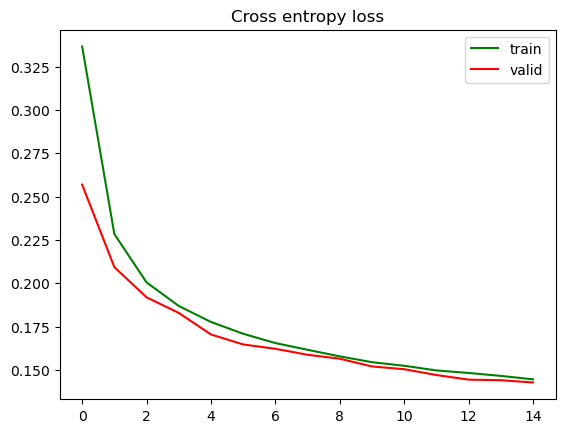

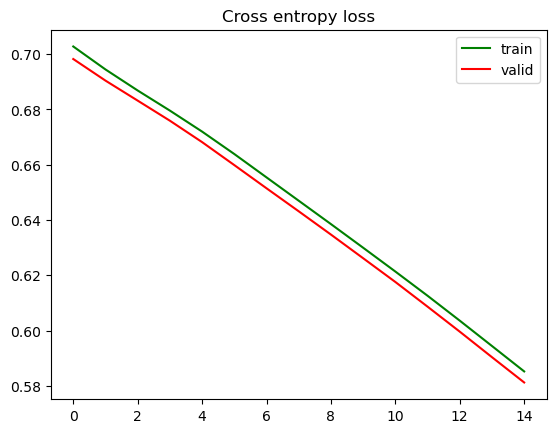

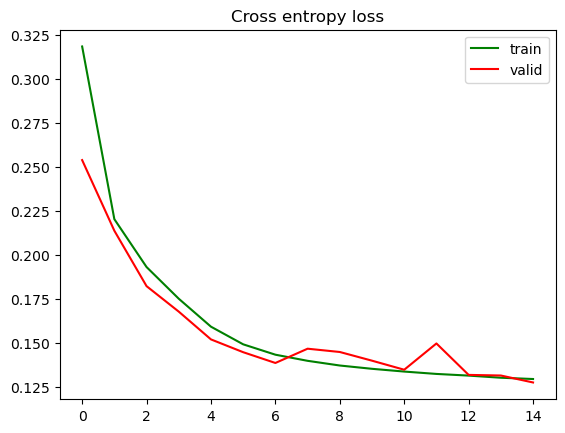

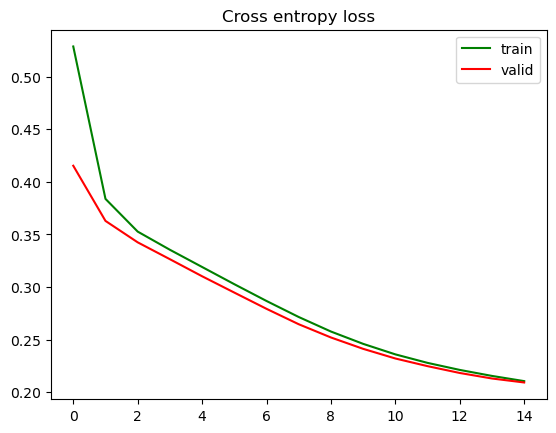

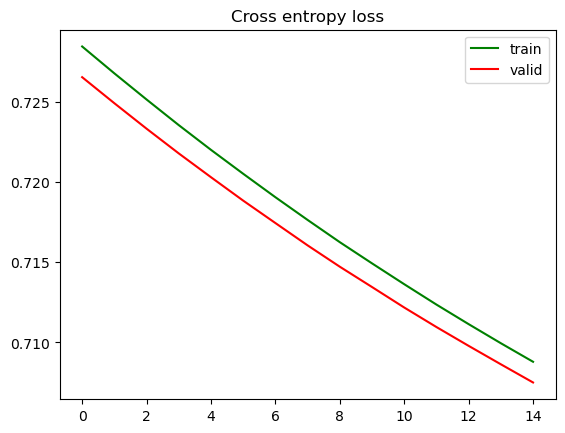

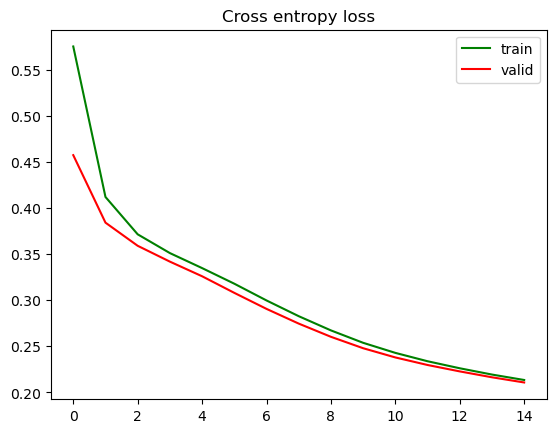

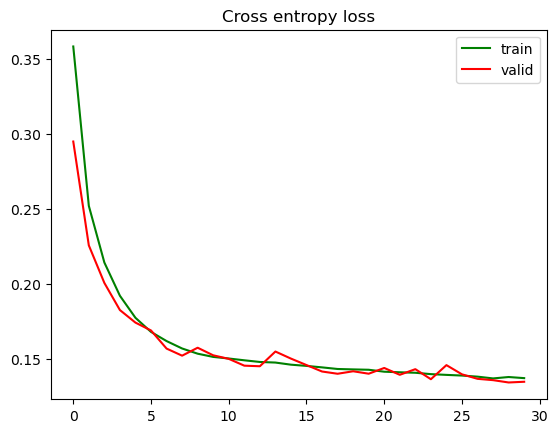

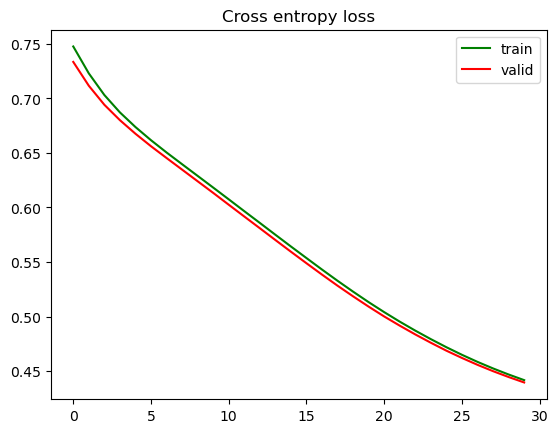

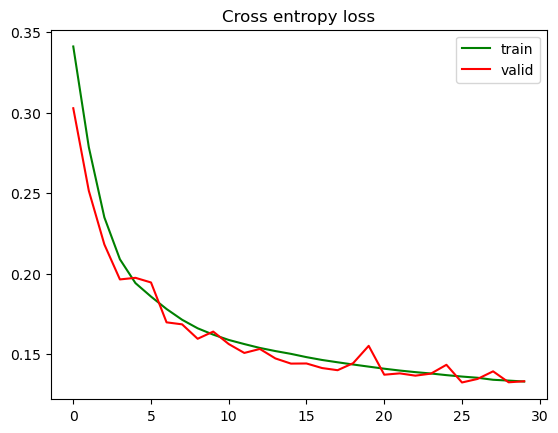

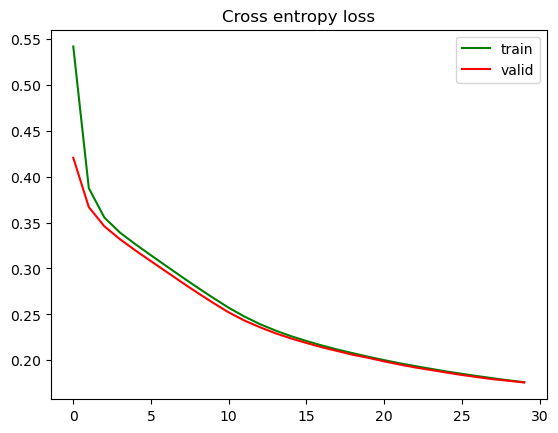

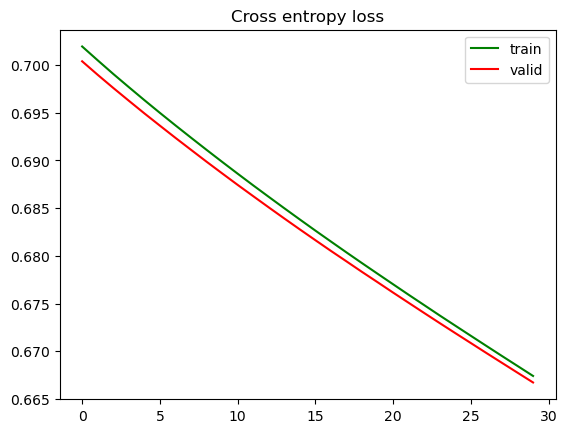

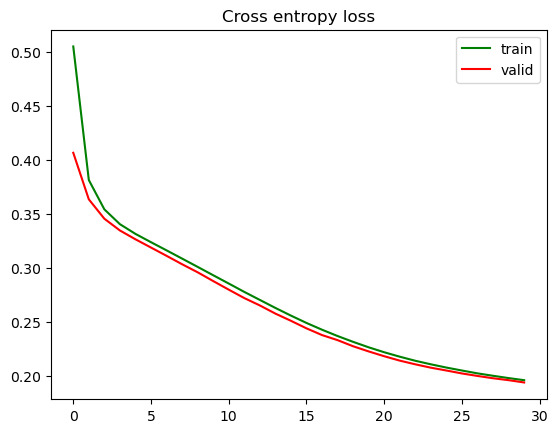

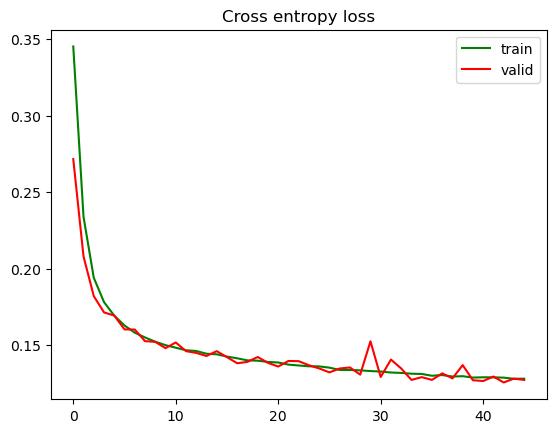

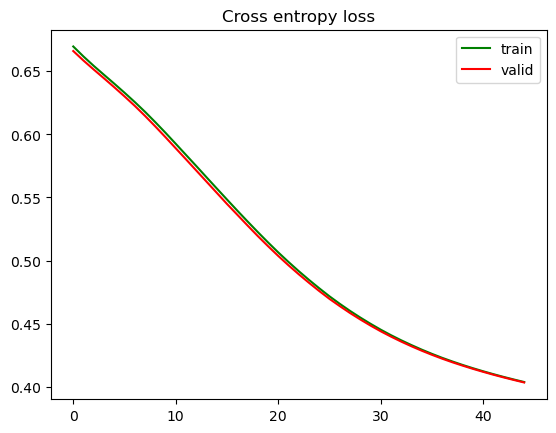

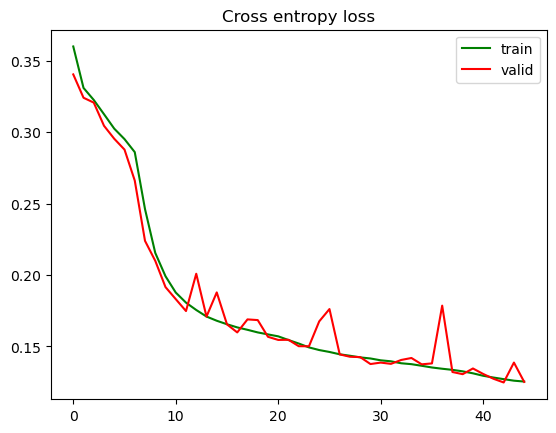

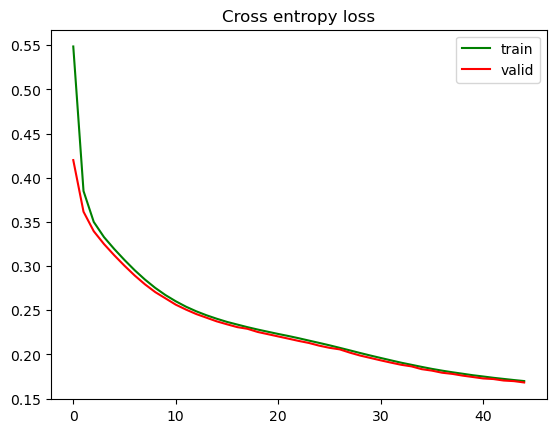

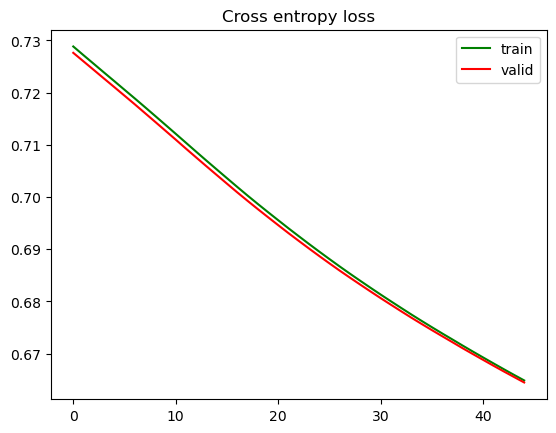

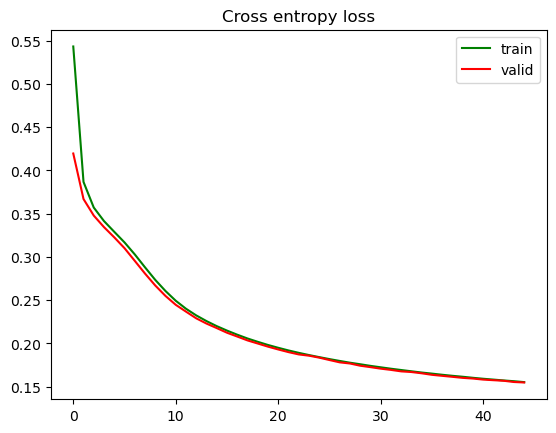

In [14]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 16, 'activation': nn.ReLU}
            ],
            'output_units': 2
        }
    ],
    'learning_rate': [0.001, 0.0001],
    'optimizer': ['Adam', 'Adadelta', 'RMSprop'],
    'epochs': [15, 30, 45]
}

best_model, best_accuracy = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)
print(f"Best parameters: {best_model.parameters()}")
print(f"Best validation accuracy: {best_accuracy:.4f}")